In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np

## LM-Algorithm

In [2]:
import torch
from tqdm.auto import tqdm
import numpy as np

# Set constant below to True if no GPU should be used. Otherwise, GPU will be used by default if exists.
CPU_ONLY = False
# If CLUSTER is False, progress bars are shown via tqdm. Otherwise, they are surpressed to reduce stdout.
CLUSTER = False


def track(iterator, **kwargs):
    if not CLUSTER:
        return tqdm(iterator, **kwargs)
    else:
        return iterator

/Users/creative/opt/anaconda3/envs/LKF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def z_score_normalize(input_tensor):
    mean = torch.mean(input_tensor)  # 计算均值
    std = torch.std(input_tensor)  # 计算标准差
    normalized_tensor = (input_tensor - mean) / std  # 标准化
    return normalized_tensor

In [4]:
# 1. Load image
resize_shape = 32
circle_image = Image.open('./data/circle2C/circle.png').convert('L').resize((resize_shape,resize_shape))
c_image = Image.open('./data/circle2C/C.png').convert('L').resize((resize_shape,resize_shape))
# c_image = Image.open('./data/circle2C/ring.png').convert('L').resize((resize_shape,resize_shape))
circle_image=torch.from_numpy(np.array(circle_image)).float().unsqueeze(0).unsqueeze(0)
c_image=torch.from_numpy(np.array(c_image)).float().unsqueeze(0).unsqueeze(0)
circle_image = z_score_normalize(circle_image)
c_image = z_score_normalize(c_image)
print("circle_image.shape: ", circle_image.shape)
print("c_image.shape: ", c_image.shape)

circle_image.shape:  torch.Size([1, 1, 32, 32])
c_image.shape:  torch.Size([1, 1, 32, 32])


### Elastic kernel

In [5]:
import numpy as np
from scipy.sparse import coo_matrix, bmat


def conv_kernel_2_sparse_mat(conv_kernel, height, width):
    # 初始化稀疏矩阵的数据列表
    rows, cols, data = [], [], []
    offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]
    
    for i in range(height):
        for j in range(width):
            img_idx = i * width + j  # 计算当前像素在展平向量中的索引
            
            for k, (di, dj) in enumerate(offsets):
                # 计算卷积核偏移位置的行列索引，使用wrap边界条件
                ni = (i + di) % height
                nj = (j + dj) % width
                neighbor_idx = ni * width + nj  # 相邻像素的展平索引
                
                # 保存索引和卷积核值
                rows.append(img_idx)
                cols.append(neighbor_idx)
                data.append(conv_kernel[di + 1, dj + 1])  # 卷积核值
                
    # 构造稀疏矩阵，形状为 (height * width, height * width)
    conv_sparse_matrix = coo_matrix((data, (rows, cols)), shape=(height * width, height * width))
    return conv_sparse_matrix


def elastic_energy_sparse_matrix(height, width, mu=2, lam=1, delta_height=1, delta_width=1):
    matrix_26 = np.array([
        [0, -(2*mu + lam) * delta_height**-2, 0],
        [-mu * delta_width**-2, mu * (4 * delta_height**-2 + 2 * delta_width**-2) + 2 * lam * delta_height**-2, -mu * delta_width**-2],
        [0, -(2*mu + lam) * delta_height**-2, 0]
    ])
    # print(matrix_26)
    matrix_27 = np.array([
        [-(mu + lam) / 4 * delta_height**-1 * delta_width**-1, 0, (mu + lam) / 4 * delta_height**-1 * delta_width**-1],
        [0, 0, 0],
        [(mu + lam) / 4 * delta_height**-1 * delta_width**-1, 0, -(mu + lam) / 4 * delta_height**-1 * delta_width**-1]
    ])
    # print(matrix_27)
    matrix_28 = np.array([
        [0, -mu * delta_height**-2, 0],
        [-(2*mu + lam) * delta_width**-2, mu * (4 * delta_width**-2 + 2 * delta_height**-2) + 2 * lam * delta_width**-2, -(2*mu + lam) * delta_width**-2],
        [0, -mu * delta_height**-2, 0]
    ])
    # print(matrix_28)
    # 将卷积矩阵转换为稀疏矩阵
    matrix_26_sparse = conv_kernel_2_sparse_mat(matrix_26, height, width)
    matrix_27_sparse = conv_kernel_2_sparse_mat(matrix_27, height, width)
    matrix_28_sparse = conv_kernel_2_sparse_mat(matrix_28, height, width)
    
    # 使用 bmat 构造稀疏矩阵 block
    matrix_H = bmat([
        [matrix_28_sparse, matrix_27_sparse],
        [matrix_27_sparse, matrix_26_sparse]
    ], format='coo')
    
    return matrix_H


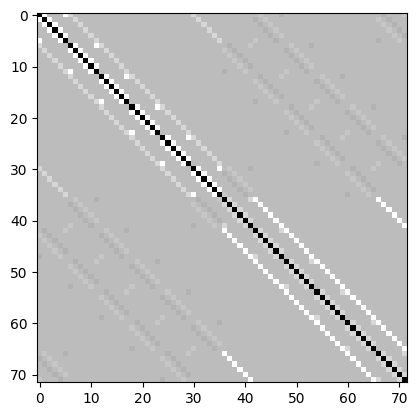

In [6]:
## plot H matrix，展示稀疏矩阵的结构
b = elastic_energy_sparse_matrix(6,6).toarray()
import matplotlib.pyplot as plt
plt.imshow(-b, cmap='gray')

In [7]:
a = elastic_energy_sparse_matrix(resize_shape,resize_shape).toarray()

### Hessian

In [8]:
import torch

def approximate_hessian(func, inputs, epsilon=1e-7):
    """
    Approximate the Hessian matrix using finite differences.
    func: Forward pass function that computes the loss.
    inputs: Tensor to compute the Hessian for.
    epsilon: Perturbation size.
    """
    # Compute the initial gradient
    initial_grad = torch.autograd.grad(func(inputs), inputs, create_graph=True)[0]

    length_x = inputs.numel() // 2

    perturbed_inputs = inputs.clone()

    # Perturb the first half of the inputs
    perturbed_inputs.view(-1)[:length_x] += epsilon

    # Compute the perturbed gradients
    perturbed_grad = torch.autograd.grad(func(perturbed_inputs), perturbed_inputs, create_graph=True)[0]

    # Compute the Hessian for the first block (A)
    hessian_column_x = (perturbed_grad - initial_grad).view(-1) / epsilon

    perturbed_inputs = inputs.clone()

    # Perturb the second half of the inputs
    perturbed_inputs.view(-1)[length_x:] += epsilon

    # Compute the perturbed gradients
    perturbed_grad = torch.autograd.grad(func(perturbed_inputs), perturbed_inputs, create_graph=True)[0]

    # Compute the Hessian for the second block (D)
    hessian_column_y = (perturbed_grad - initial_grad).view(-1) / epsilon

    # Now we want to form the block diagonal Hessian matrix:
    # Block structure: 
    # [Diag(A), Diag(C); Diag(B), Diag(D)]
    A = hessian_column_x[:length_x]
    B = hessian_column_x[length_x:]
    C = hessian_column_y[:length_x]
    D = hessian_column_y[length_x:]

    # Create the block diagonal Hessian matrix
    hessian_matrix = torch.zeros(2 * length_x, 2 * length_x, device=inputs.device)

    # Diagonal blocks (A, D) on the diagonal
    hessian_matrix[:length_x, :length_x] = torch.diag(A)
    hessian_matrix[length_x:, length_x:] = torch.diag(D)

    # Off-diagonal blocks (B, C)
    hessian_matrix[:length_x, length_x:] = torch.diag(B)
    hessian_matrix[length_x:, :length_x] = torch.diag(C)

    hessian_matrix = (hessian_matrix + hessian_matrix.t()) / 2
    return hessian_matrix


In [10]:
from register.SpatialTransformer2 import SpatialTransformer2
## 判断a是不是numpy
if isinstance(a,np.ndarray):
     a=torch.from_numpy(a).float()  # 转换为tensor
device=torch.device("cpu")  # 使用GPU
model=SpatialTransformer2(circle_image.shape[2:],10)  # 生成模型
circle_image=circle_image.to(device)
c_image=c_image.to(device)
model=model.to(device)
a = a.to(device)
loss_fn=nn.MSELoss(reduction='sum')   # MSE作为loss
basic_flow_shape = model.basic_flows.shape

## 超参数
eta = 1
eye_matrix = eta * torch.eye(2 * resize_shape ** 2).to(device)

In [23]:
t = track(range(300), leave=False, desc="Epoch iteration")
for i in  t:
    loss=loss_fn(model(circle_image), c_image)   # 计算loss
    if hasattr(t, "set_description"):
            t.set_description("Model update loop, loss: %4.2f" % (loss/circle_image.numel()))

    loss.backward(retain_graph=True)
    grad = model.basic_flows.grad.view(-1, 1)
    def hessian_forward(flows):
         loss = loss_fn(model(circle_image,flows), c_image) /2
         return loss

    hess = approximate_hessian(hessian_forward, model.basic_flows)
    # print(hess.sum())
    with torch.no_grad():
        model.basic_flows.data  = (model.basic_flows.view(-1,1) - torch.linalg.solve(a+hess+eye_matrix, grad + a @ model.basic_flows.view(-1, 1))).view(*basic_flow_shape)

Model update loop, loss: 0.93:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
basic_flow_shape

torch.Size([1, 2, 32, 32])

In [12]:
predict_image=model(circle_image) 

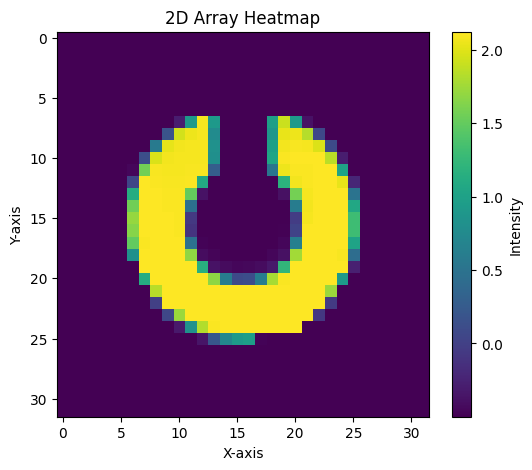

tensor(6.8816, device='cuda:3', grad_fn=<MseLossBackward0>)

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 创建一个示例的 2D 张量
tensor_2d = torch.rand(10, 10)  # 创建 10x10 的随机张量

# 将 PyTorch 张量转换为 NumPy 数组

# 绘制热力图
plt.figure(figsize=(6, 5))
plt.imshow(predict_image.squeeze().cpu().detach().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='Intensity')
plt.title('2D Array Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()
loss

## Adam Optimizer

In [27]:
from register.SpatialTransformer2 import SpatialTransformer2
from register.LocalDisplacementEnergy import BendingEnergy

model=SpatialTransformer2(circle_image.shape[2:],10)  # 生成模型
device=torch.device("cpu")  # 使用GPU
circle_image=circle_image.to(device)
c_image=c_image.to(device)
model=model.to(device)
opt=torch.optim.Adam(model.parameters(), lr=0.05)  # Adam优化器
loss_fn=nn.MSELoss()   # MSE作为loss
bending_energy = BendingEnergy(alpha=1, dimension=2)  # 弯曲能量作为正则项

for i in range(20000):
    loss=loss_fn(model(circle_image), c_image)  # 计算loss
    flows=[flows for flows in model.parameters()][0]  # 获取流场
    loss += bending_energy(flows)  # 加上正则项

    if (i + 1) % 200 == 0:
        print(i, " loss(with reg): ", loss)  # 打印loss

    opt.zero_grad()  # 梯度清零
    loss.backward(retain_graph=True)  # 反向传播
    opt.step()  # 更新参数

/Users/creative/opt/anaconda3/envs/pytorch-nightly/lib/python3.8/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


199  loss(with reg):  tensor(0.4658, grad_fn=<AddBackward0>)
399  loss(with reg):  tensor(0.2359, grad_fn=<AddBackward0>)
599  loss(with reg):  tensor(0.1100, grad_fn=<AddBackward0>)
799  loss(with reg):  tensor(0.0916, grad_fn=<AddBackward0>)
999  loss(with reg):  tensor(0.0827, grad_fn=<AddBackward0>)
1199  loss(with reg):  tensor(0.0772, grad_fn=<AddBackward0>)
1399  loss(with reg):  tensor(0.0738, grad_fn=<AddBackward0>)
1599  loss(with reg):  tensor(0.0709, grad_fn=<AddBackward0>)
1799  loss(with reg):  tensor(0.0689, grad_fn=<AddBackward0>)
1999  loss(with reg):  tensor(0.0671, grad_fn=<AddBackward0>)
2199  loss(with reg):  tensor(0.0653, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [8]:
for i in range(20000,60000):
    loss=loss_fn(model(circle_image), c_image)  # 计算loss
    flows=[flows for flows in model.parameters()][0]  # 获取流场
    loss += bending_energy(flows)  # 加上正则项

    if (i + 1) % 200 == 0:
        print(i, " loss(with reg): ", loss)  # 打印loss

    opt.zero_grad()  # 梯度清零
    loss.backward(retain_graph=True)  # 反向传播
    opt.step()  # 更新参数

20199  loss(with reg):  tensor(0.0066, device='cuda:1', grad_fn=<AddBackward0>)
20399  loss(with reg):  tensor(0.0065, device='cuda:1', grad_fn=<AddBackward0>)
20599  loss(with reg):  tensor(0.0064, device='cuda:1', grad_fn=<AddBackward0>)
20799  loss(with reg):  tensor(0.0064, device='cuda:1', grad_fn=<AddBackward0>)
20999  loss(with reg):  tensor(0.0062, device='cuda:1', grad_fn=<AddBackward0>)
21199  loss(with reg):  tensor(0.0062, device='cuda:1', grad_fn=<AddBackward0>)
21399  loss(with reg):  tensor(0.0061, device='cuda:1', grad_fn=<AddBackward0>)
21599  loss(with reg):  tensor(0.0060, device='cuda:1', grad_fn=<AddBackward0>)
21799  loss(with reg):  tensor(0.0058, device='cuda:1', grad_fn=<AddBackward0>)
21999  loss(with reg):  tensor(0.0058, device='cuda:1', grad_fn=<AddBackward0>)
22199  loss(with reg):  tensor(0.0057, device='cuda:1', grad_fn=<AddBackward0>)
22399  loss(with reg):  tensor(0.0056, device='cuda:1', grad_fn=<AddBackward0>)
22599  loss(with reg):  tensor(0.0056, d

In [10]:
torch.save(model.state_dict(), './data/circle2C/model/train_model_name.pth')  # 保存模型

In [9]:
loss_fn(model(circle_image), c_image),loss_fn(circle_image, c_image)  # 计算loss

(tensor(0.0005, device='cuda:1', grad_fn=<MseLossBackward0>),
 tensor(1.1369, device='cuda:1'))

In [1]:
import matplotlib.pyplot as plt
from register.SpatialTransformer2 import SpatialTransformer2
from register.LocalDisplacementEnergy import BendingEnergy

model=SpatialTransformer2(circle_image.shape[2:],10)  # 生成模型
model.load_state_dict(torch.load('./data/circle2C/model/best_model.pth'))  # 加载模型
device=torch.device("cuda:1")  # 使用GPU
circle_image=circle_image.to(device)
c_image=c_image.to(device)
model=model.to(device)
output=model(circle_image).cpu().detach().numpy().squeeze()
output=(output-np.min(output))/(np.max(output)-np.min(output))*255
image=Image.fromarray(output.astype(np.uint8))
image.save('./data/circle2C/output/output.png')
plt.imshow(output, cmap='gray')
plt.show()

NameError: name 'circle_image' is not defined

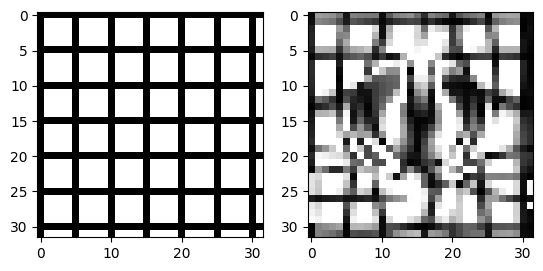

In [17]:
lattice=np.ones((32,32))
lattice[0:32:5,:]=0
lattice[:,0:32:5]=0
lattice=lattice*255
norm_lattice = z_score_normalize(torch.from_numpy(np.array(lattice)).float().unsqueeze(0).unsqueeze(0))
warped_norm_lattice=model(norm_lattice.to(device)).squeeze().cpu().detach().numpy().squeeze()

plt.subplot(1,2,1)
plt.imshow(lattice,cmap='gray')

plt.subplot(1,2,2)
warped_norm_lattice=(warped_norm_lattice-np.min(warped_norm_lattice))/(np.max(warped_norm_lattice)-np.min(warped_norm_lattice))*255
image=Image.fromarray(warped_norm_lattice.astype(np.uint8))
image.save('./data/circle2C/output/warped_norm_lattice.png')
plt.imshow(warped_norm_lattice, cmap='gray')
plt.show()

inverse

In [47]:
from register.InverseSpatialTransformer2 import InverseSpatialTransformer2
Inverse_model=InverseSpatialTransformer2(circle_image.shape[2:],10)

device=torch.device("cuda:1")
Inverse_model.load_state_dict(torch.load('./data/circle2C/model/best_model.pth'))

Inverse_model=Inverse_model.to(device)

loss_fn=nn.MSELoss()

inverse=Inverse_model(c_image)
loss_fn(inverse,circle_image)



tensor(0.0104, device='cuda:1', grad_fn=<MseLossBackward0>)

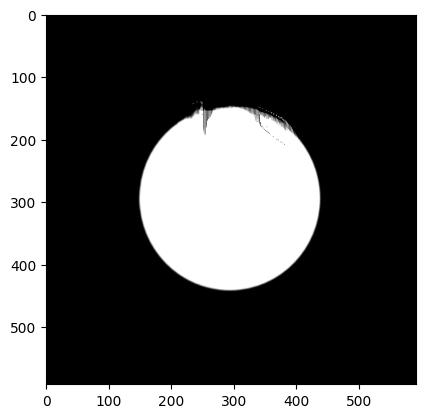

In [48]:
import matplotlib.pyplot as plt
inverse=inverse.cpu().detach().numpy().squeeze()
inverse=(inverse-np.min(inverse))/(np.max(inverse)-np.min(inverse))*255
image=Image.fromarray(inverse.astype(np.uint8))
image.save('./data/circle2C/output/inverse.png')
plt.imshow(inverse, cmap='gray')
plt.show()